In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs, make_biclusters, make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
class Support_Vector_Machine:
    def __init__(self, C = 1.0, kernel = 'rbf', degree = 3, gamma = 'scale',
                 coef0 = 0.0, tol = 0.001, verbose = False, max_passes = 5, eps = 1e-05):
        '''
        This class performs binary classification using Support Vector Algorithm (optimization using SMO algorithm)
        C: Regularization Parameter (default = 1.0)
        kernel: 'rbf', 'linear', 'polynomial', 'sigmoid' (default: 'rbf')
        degree: degree of polynomial kernel (default: 3)
        gamma: parameter for rbf and polynomial kernel. scale /auto as per definitions provided in
        https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
        coef0: Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’ (default: 0.0)
        tol: Tolerance for stopping criterion (default: 0.001)
        verbose: Boolean parameter which shows progress of the algorithm (default: False)
        max_passes: Maximum number of passes through the training data (default: 5)
        eps: Epsilon parameter used in the algorithm (refer Platt's paper) (default: 1e-05)
        '''
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.verbose = verbose
        # Maximum number of passes through training data
        self.max_passes = max_passes
        self.eps = eps
        
    def fit(self, X, y):
        '''
        This function performs training of the Support Vector Machine algorithm on training data.
        X: Feature matrix of shape (m, n), m = Number of training examples, n = number of features
        y: Target vector of shape (m,), m = Number of training examples
        '''
        self.X = X
        self.y = y
        self.m = X.shape[0]
        if np.ndim(X) > 1:
            self.n = X.shape[1]
        else:
            self.n = 1
        if self.gamma == 'scale':
            self.gamma_val = 1 / (self.n * np.var(X))
        else:
            self.gamma_val = 1 / self.n
        self._objective = []
        self.alphas = np.zeros(self.m)
        self.b = 0.0
        self.errors = self.decision_function(self.X) - self.y
        numchanged = 0
        examineall = 1
        passes = 0
        while (numchanged > 0) or (examineall):
            numchanged = 0
            if examineall:
                for i in range(self.alphas.shape[0]):
                    examine_result = self.examine_example(i)
                    numchanged = numchanged + examine_result
                    if examine_result:
                        objective = self.objective_calc(self.alphas)
                        self._objective.append(objective)
            else:
                for i in np.where((self.alphas != 0) & (self.alphas != self.C))[0]:
                    examine_result = self.examine_example(i)
                    numchanged = numchanged + examine_result
                    if examine_result:
                        objective = self.objective_calc(self.alphas)
                        self._objective.append(objective)
            if examineall == 1:
                examineall = 0
            elif numchanged == 0:
                examineall = 1
            if numchanged > 0 and self.verbose:
                passes += 1
                print('Pass: {}, Objective Function: {}'.format(passes, self._objective[-1]))
            if passes == self.max_passes:
                if self.verbose:
                    print('Passes through training data completed')
                break
                
    def examine_example(self, i2):
        y2 = self.y[i2]
        alpha2 = self.alphas[i2]
        e2 = self.errors[i2]
        r2 = e2 * y2
        if ((r2 < -self.tol and alpha2 < self.C) or (r2 > self.tol and alpha2 > 0)):
            if len(self.alphas[(self.alphas != 0) & (self.alphas != self.C)]) > 1:
                if self.errors[i2] > 0:
                    i1 = np.argmin(self.errors)
                else:
                    i1 = np.argmax(self.errors)
                step_result = self.takestep(i1, i2)
                if step_result:
                    return 1
        
            for i1 in np.roll(np.where((self.alphas != 0) & (self.alphas != self.C))[0], np.random.choice(np.arange(self.m))):
                step_result = self.takestep(i1, i2)
                if step_result:
                    return 1
        
            for i1 in np.roll(np.arange(self.m), np.random.choice(np.arange(self.m))):
                step_result = self.takestep(i1, i2)
                if step_result:
                    return 1
        return 0
    
    def takestep(self, i1, i2):
        if i1 == i2:
            return 0
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        e1 = self.errors[i1]
        e2 = self.errors[i2]
        s = y1 * y2
        if s > 0:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)
        else:
            L = max([0, alpha2 - alpha1])
            H = min([self.C, self.C + alpha2 - alpha1])
        if L == H:
            return 0
        k11 = self.kernel_calc(self.X[i1], self.X[i1])
        k22 = self.kernel_calc(self.X[i2], self.X[i2])
        k12 = self.kernel_calc(self.X[i1], self.X[i2])
        eta = 2 * k12 - k11 - k22
        if eta < 0:
            a2 = alpha2 - ((y2 * (e1 - e2)) / eta)
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        else:
            alphas_adj = self.alphas.copy()
            alphas_adj[i2] = L
            lobj = self.objective_calc(alphas_adj)
            alphas_adj[i2] = H
            hobj = self.objective_calc(alphas_adj)
            if lobj < (hobj - self.eps):
                a2 = H
            elif lobj > (hobj + self.eps):
                a2 = L
            else:
                a2 = alpha2

        # Pushing a2 to O or C if very close
        if a2 < 1e-05:
            a2 = 0.0
        elif a2 > (self.C - 1e-05):
            a2 = self.C

        if np.abs(a2 - alpha2) < (self.eps * (a2 + alpha2 + self.eps)):
            return 0
        a1 = alpha1 + (s * (alpha2 - a2))

        b1 = e1 + (y1 * (a1 - alpha1) * k11) + (y2 * (a2 - alpha2) * k12) + self.b
        b2 = e2 + (y1 * (a1 - alpha1) * k12) + (y2 * (a2 - alpha2) * k22) + self.b
        if a1 > 0 and a1 < self.C:
            b_new = b1
        elif a2 > 0 and a2 < self.C:
            b_new = b2
        else:
            b_new = 0.5 * (b1 + b2)
            
        # Update the lagrangian parameter matrix
        self.alphas[i1] = a1
        self.alphas[i2] = a2
        
        # Update error matrix
        for index, alph in zip([i1, i2], [a1, a2]):
            if 0.0 < alph < self.C:
                self.errors[index] = 0
        non_opt = [n for n in range(self.m) if (n != i1 and n!= i2)]
        self.errors[non_opt] += (y1 * (a1 - alpha1) * self.kernel_calc(self.X[i1], self.X[non_opt])) + \
                                                       (y2 * (a2 - alpha2) * self.kernel_calc(self.X[i2],self.X[non_opt])) + \
                                                       self.b - b_new
        self.b =b_new
        return 1
    
    def objective_calc(self, alphas):
        objective = np.sum(self.alphas) - \
        0.5 * np.sum((self.y[:, None] * self.y[None,:]) * self.kernel_calc(self.X, self.X) * \
                     (self.alphas[:, None] * self.alphas[None, :]))
        return objective
    
    def decision_function(self, X_test):
        decision_array = (self.alphas * self.y) @ self.kernel_calc(self.X, X_test) - self.b
        return decision_array
        
    def kernel_calc(self, x, y):
        if self.kernel == 'rbf':
            if np.ndim(x) == 1 and np.ndim(y) == 1:
                return np.exp(- self.gamma_val * (np.linalg.norm(x - y, 2)) ** 2)
            elif (np.ndim(x) == 1 and np.ndim(y) > 1) or (np.ndim(x) > 1 and np.ndim(y) == 1):
                return np.exp(- self.gamma_val * (np.linalg.norm(x - y, 2, axis = 1)) ** 2)
            else:
                return np.exp(- self.gamma_val * (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis = 2)) ** 2)
        elif self.kernel == 'linear':
            return np.matmul(x, y.T) + 1
        elif self.kernel == 'polynomial':
            return np.power((self.gamma_val * np.matmul(x, y.T) + self.coef0), self.degree)
        elif self.kernel == 'sigmoid':
            return np.tanh(self.gamma_val * np.matmul(x, y.T) + self.coef0)
        
    def plot_decision_boundary(self, X, y, resolution = 100, colors = ('b', 'k', 'r'), levels = (-1, 0, 1), title = ''):
        xrange = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, resolution)
        yrange = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, resolution)
        grid =[[self.decision_function(np.array([xr, yr])) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        fig, ax = plt.subplots(figsize = (12, 8))
        ax.contour(xrange, yrange, grid, levels = levels, linewidths = (1, 1, 1),
                   linestyles = ('--', '-', '--'), colors = colors)
        ax.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.viridis, lw = 0, alpha = 0.6)

        mask = np.round(self.alphas, decimals = 2) != 0.0
        ax.scatter(X[mask, 0], X[mask, 1], c = y[mask], cmap = plt.cm.viridis, lw = 1, edgecolors = 'k')
        ax.set_title(title)
        return ax
    
    def predict(self, X):
        decision_fun = self.decision_function(X)
        return np.where(decision_fun < 0, -1, 1)
    
    @staticmethod
    def metrics_calc(y, y_pred):
        accuracy = np.round((np.sum(y == y_pred) / y.shape[0]) * 100, 2)
        return accuracy
    
    def __del__(self):
        print('')

In [3]:
# Creating synthetic data using Sci-kit learn
X, y = make_classification(n_samples = 500, n_features = 2, n_informative = 2, n_redundant = 0,
                           n_repeated = 0, class_sep = 0.8, random_state = 1)
y[y == 0] = -1

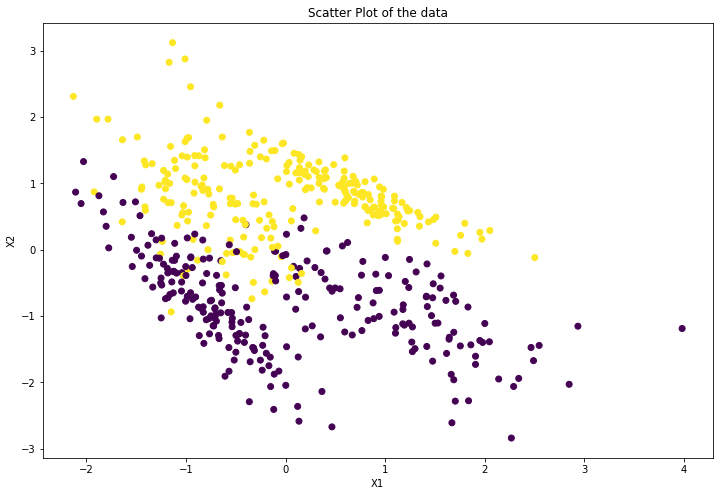

In [4]:
# Visualizing the data
plt.figure(figsize = (12, 8))
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of the data');

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [6]:
scaler1 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train, y_train)
X_test_scaled = scaler1.transform(X_test)

# Usage of Linear Kernel:

Train accuracy with C: 1 is 92.0
Test accuracy with C: 1 is 86.4

Train accuracy with C: 10 is 91.47
Test accuracy with C: 10 is 86.4

Train accuracy with C: 100 is 90.13
Test accuracy with C: 100 is 86.4



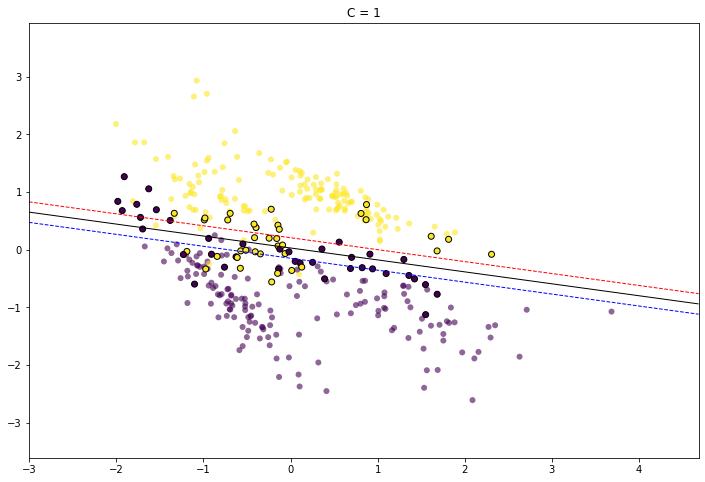

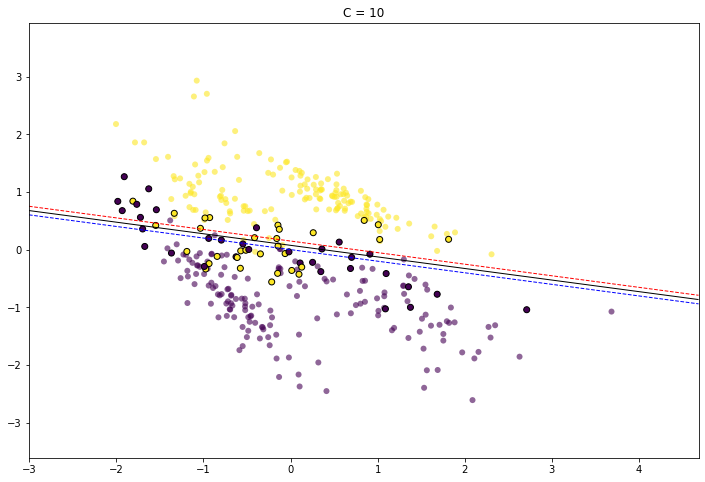

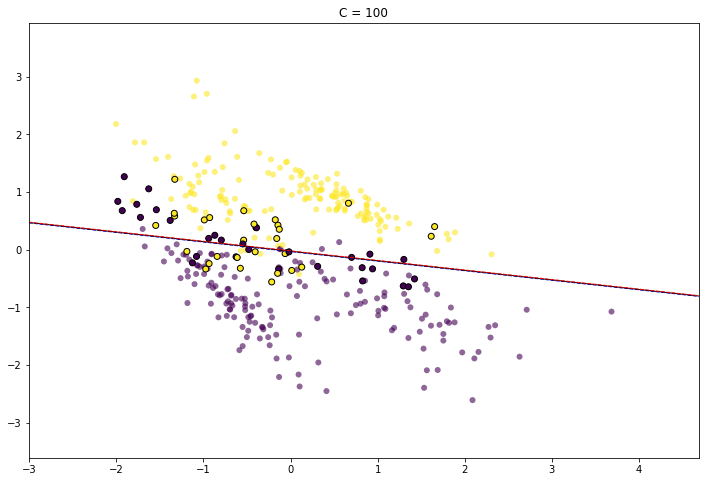

In [7]:
np.random.seed(0)

for i in [1, 10, 100]:
    clf1 = Support_Vector_Machine(C = i, kernel = 'linear')
    clf1.fit(X_train_scaled, y_train)
    clf1.plot_decision_boundary(X_train_scaled, y_train, title = 'C = {}'.format(i))
    y_train_pred = clf1.predict(X_train_scaled)
    y_test_pred = clf1.predict(X_test_scaled)
    train_acc = Support_Vector_Machine.metrics_calc(y_train, y_train_pred)
    test_acc = Support_Vector_Machine.metrics_calc(y_test, y_test_pred)
    print('Train accuracy with C: {} is {}'.format(i, train_acc))
    print('Test accuracy with C: {} is {}'.format(i, test_acc))
    del clf1

# Usage of RBF Kernel

Train accuracy with C: 1 is 93.33
Test accuracy with C: 1 is 88.8

Train accuracy with C: 10 is 92.27
Test accuracy with C: 10 is 90.4

Train accuracy with C: 100 is 92.8
Test accuracy with C: 100 is 88.8



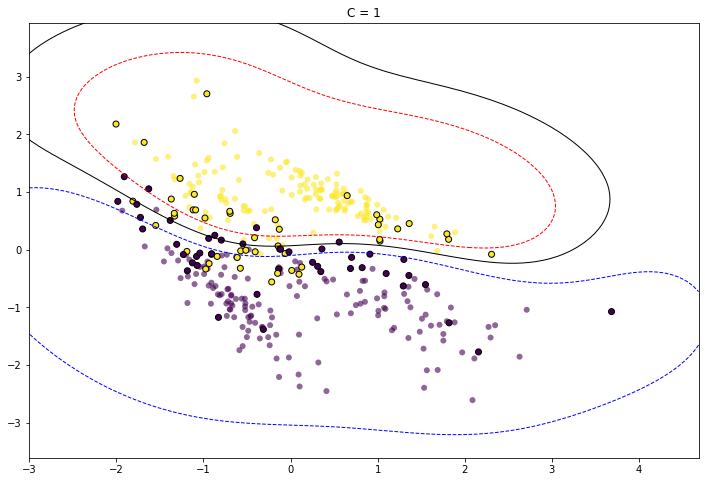

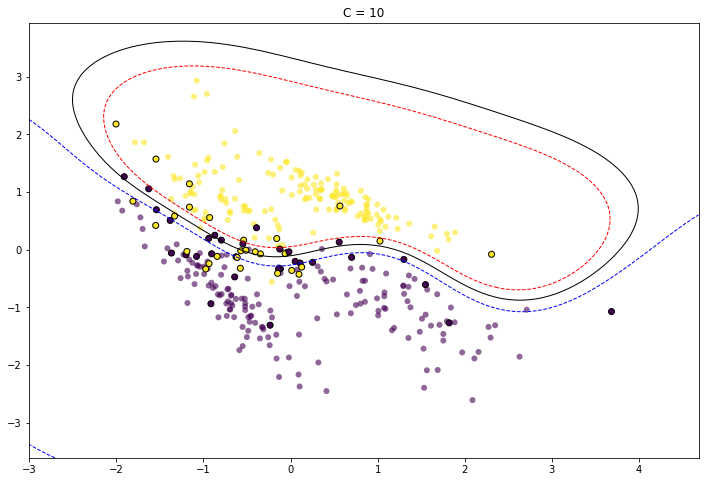

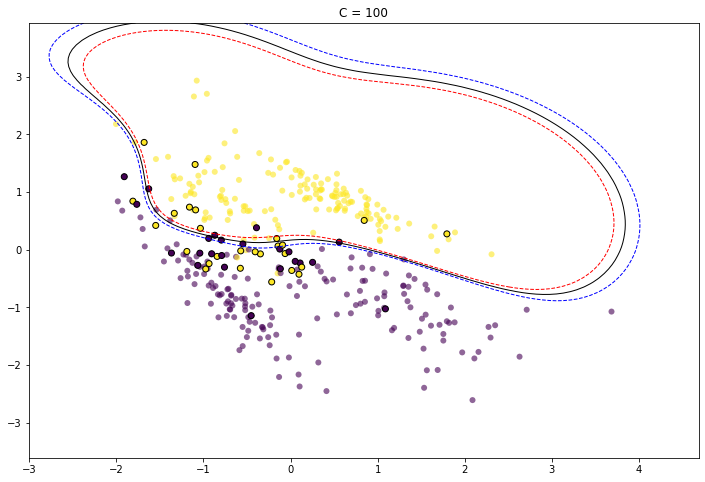

In [8]:
for i in [1, 10, 100]:
    clf1 = Support_Vector_Machine(C = i, kernel = 'rbf')
    clf1.fit(X_train_scaled, y_train)
    clf1.plot_decision_boundary(X_train_scaled, y_train, title = 'C = {}'.format(i))
    y_train_pred = clf1.predict(X_train_scaled)
    y_test_pred = clf1.predict(X_test_scaled)
    train_acc = Support_Vector_Machine.metrics_calc(y_train, y_train_pred)
    test_acc = Support_Vector_Machine.metrics_calc(y_test, y_test_pred)
    print('Train accuracy with C: {} is {}'.format(i, train_acc))
    print('Test accuracy with C: {} is {}'.format(i, test_acc))
    del clf1

# Usage of Polynomial Kernel

Train accuracy with C: 1 is 85.33
Test accuracy with C: 1 is 83.2

Train accuracy with C: 10 is 88.0
Test accuracy with C: 10 is 87.2

Train accuracy with C: 100 is 90.13
Test accuracy with C: 100 is 86.4



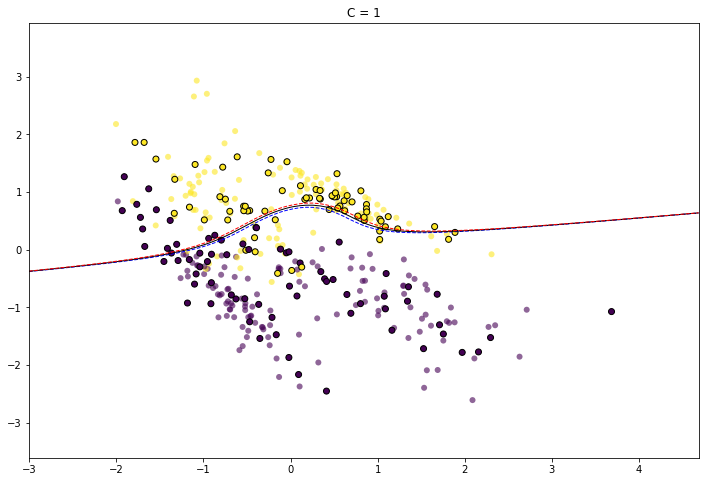

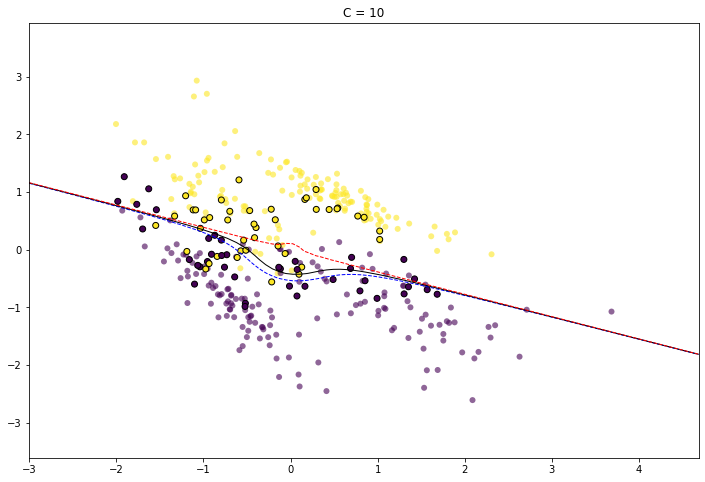

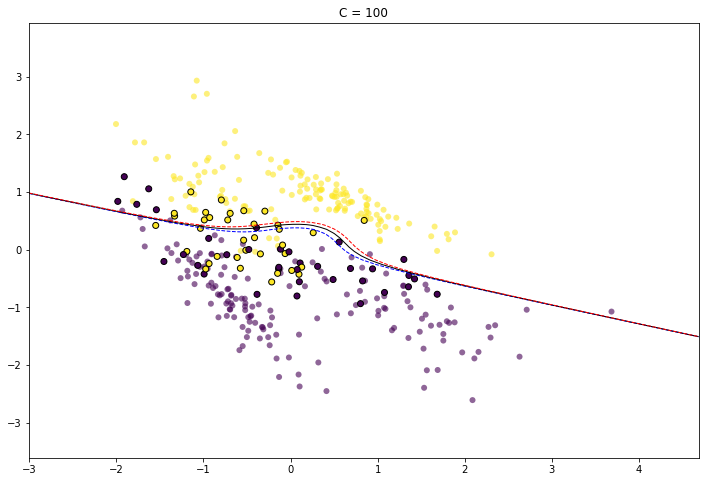

In [9]:
for i in [1, 10, 100]:
    clf1 = Support_Vector_Machine(C = i, kernel = 'polynomial')
    clf1.fit(X_train_scaled, y_train)
    clf1.plot_decision_boundary(X_train_scaled, y_train, title = 'C = {}'.format(i))
    y_train_pred = clf1.predict(X_train_scaled)
    y_test_pred = clf1.predict(X_test_scaled)
    train_acc = Support_Vector_Machine.metrics_calc(y_train, y_train_pred)
    test_acc = Support_Vector_Machine.metrics_calc(y_test, y_test_pred)
    print('Train accuracy with C: {} is {}'.format(i, train_acc))
    print('Test accuracy with C: {} is {}'.format(i, test_acc))
    del clf1

Train accuracy with C: 1 is 90.4
Test accuracy with C: 1 is 84.8

Train accuracy with C: 10 is 88.27
Test accuracy with C: 10 is 88.0

Train accuracy with C: 100 is 88.8
Test accuracy with C: 100 is 83.2



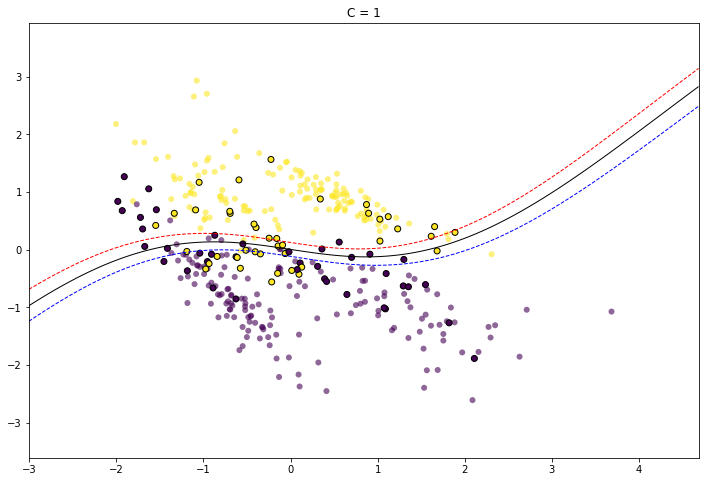

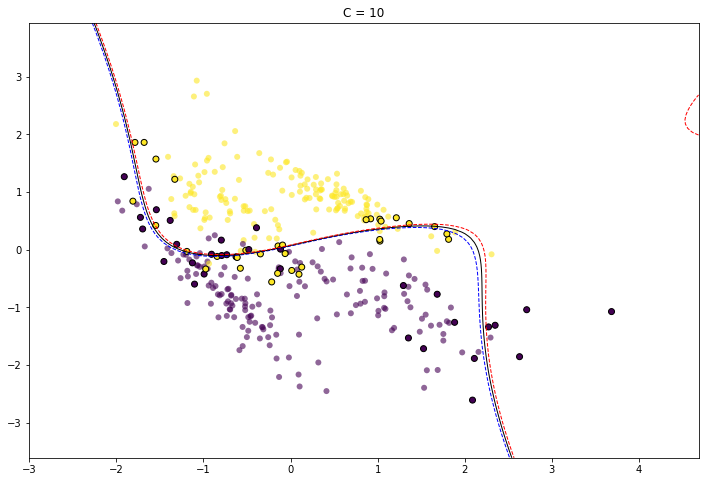

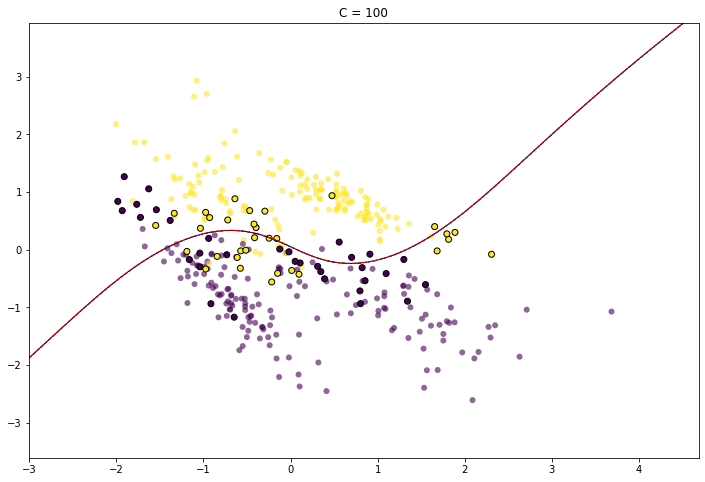

In [10]:
for i in [1, 10, 100]:
    clf1 = Support_Vector_Machine(C = i, kernel = 'sigmoid')
    clf1.fit(X_train_scaled, y_train)
    clf1.plot_decision_boundary(X_train_scaled, y_train, title = 'C = {}'.format(i))
    y_train_pred = clf1.predict(X_train_scaled)
    y_test_pred = clf1.predict(X_test_scaled)
    train_acc = Support_Vector_Machine.metrics_calc(y_train, y_train_pred)
    test_acc = Support_Vector_Machine.metrics_calc(y_test, y_test_pred)
    print('Train accuracy with C: {} is {}'.format(i, train_acc))
    print('Test accuracy with C: {} is {}'.format(i, test_acc))
    del clf1